In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
data = "../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(data)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Copy for feature engineering
df_fe = df.copy()

# Drop customerID
df_fe = df_fe.drop('customerID', axis=1)

# Fix TotalCharges
df_fe['TotalCharges'] = pd.to_numeric(df_fe['TotalCharges'], errors='coerce')
df_fe['TotalCharges'] = df_fe['TotalCharges'].fillna(0)

# Convert target to binary
df_fe['Churn'] = df_fe['Churn'].map({'No': 0, 'Yes': 1})

print(f"After cleaning: {df_fe.shape}")
df_fe.info()

After cleaning: (7043, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod  

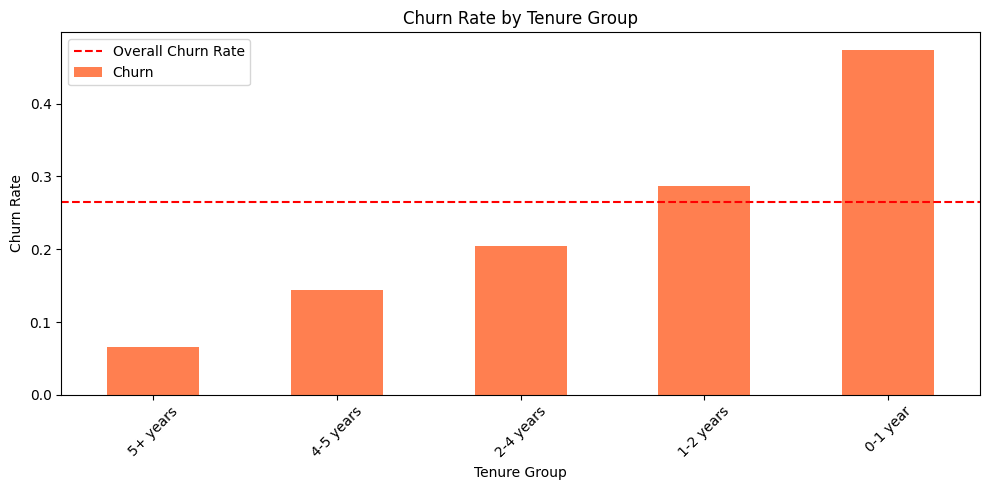

Churn rate by tenure group:
tenure_group
5+ years     0.066098
4-5 years    0.144231
2-4 years    0.203890
1-2 years    0.287109
0-1 year     0.474382
Name: Churn, dtype: float64


In [4]:
# Create tenure groups
def create_tenure_groups(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 48:
        return '2-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'

df_fe['tenure_group'] = df_fe['tenure'].apply(create_tenure_groups)

# Visualize churn by tenure group
plt.figure(figsize=(10, 5))
churn_by_tenure = df_fe.groupby('tenure_group')['Churn'].mean().sort_values()
churn_by_tenure.plot(kind='bar', color='coral')
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.axhline(y=df_fe['Churn'].mean(), color='red', linestyle='--', label='Overall Churn Rate')
plt.legend()
plt.tight_layout()
plt.show()

print("Churn rate by tenure group:")
print(churn_by_tenure)

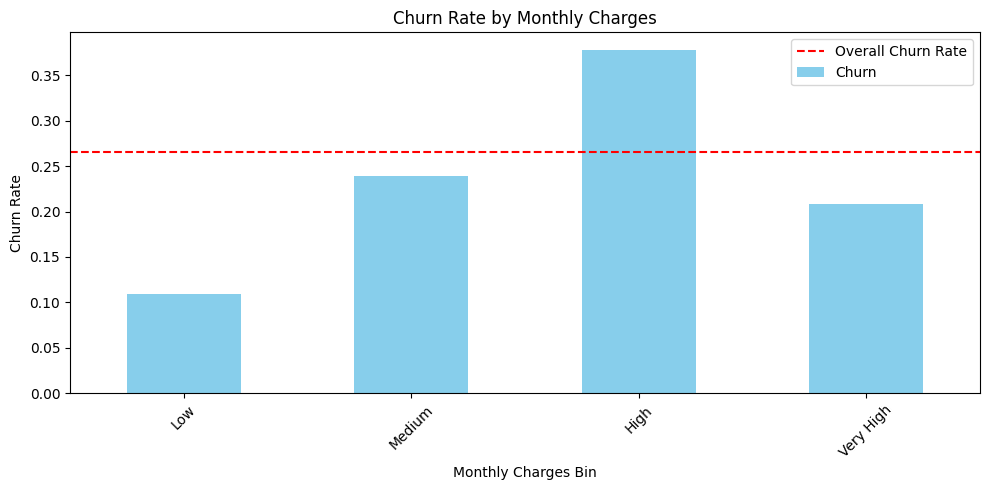

Churn rate by monthly charges:
monthly_charges_bin
Low          0.108934
Medium       0.239420
High         0.378140
Very High    0.208494
Name: Churn, dtype: float64


In [5]:
# Create monthly charges bins
df_fe['monthly_charges_bin'] = pd.cut(
    df_fe['MonthlyCharges'], 
    bins=[0, 35, 70, 105, 120],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Visualize
plt.figure(figsize=(10, 5))
churn_by_charges = df_fe.groupby('monthly_charges_bin')['Churn'].mean()
churn_by_charges.plot(kind='bar', color='skyblue')
plt.title('Churn Rate by Monthly Charges')
plt.xlabel('Monthly Charges Bin')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.axhline(y=df_fe['Churn'].mean(), color='red', linestyle='--', label='Overall Churn Rate')
plt.legend()
plt.tight_layout()
plt.show()

print("Churn rate by monthly charges:")
print(churn_by_charges)

Service count distribution:
service_count
0      80
1    1701
2    1188
3     965
4     922
5     908
6     676
7     395
8     208
Name: count, dtype: int64


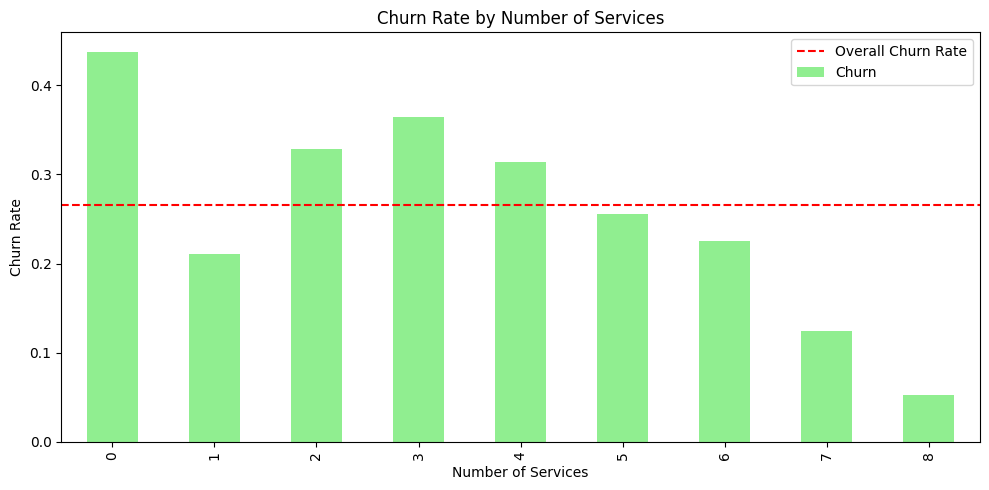

In [6]:
# Average monthly charges
df_fe['avg_monthly_charges'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)  # +1 to avoid division by zero

# Charges ratio (how much of total is monthly)
df_fe['charges_ratio'] = df_fe['MonthlyCharges'] / (df_fe['TotalCharges'] + 1)

# Service usage count (how many services customer uses)
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Count 'Yes' responses
df_fe['service_count'] = 0
for col in service_cols:
    if col in df_fe.columns:
        df_fe['service_count'] += (df_fe[col] == 'Yes').astype(int)

print("Service count distribution:")
print(df_fe['service_count'].value_counts().sort_index())

# Visualize churn by service count
plt.figure(figsize=(10, 5))
churn_by_services = df_fe.groupby('service_count')['Churn'].mean()
churn_by_services.plot(kind='bar', color='lightgreen')
plt.title('Churn Rate by Number of Services')
plt.xlabel('Number of Services')
plt.ylabel('Churn Rate')
plt.axhline(y=df_fe['Churn'].mean(), color='red', linestyle='--', label='Overall Churn Rate')
plt.legend()
plt.tight_layout()
plt.show()

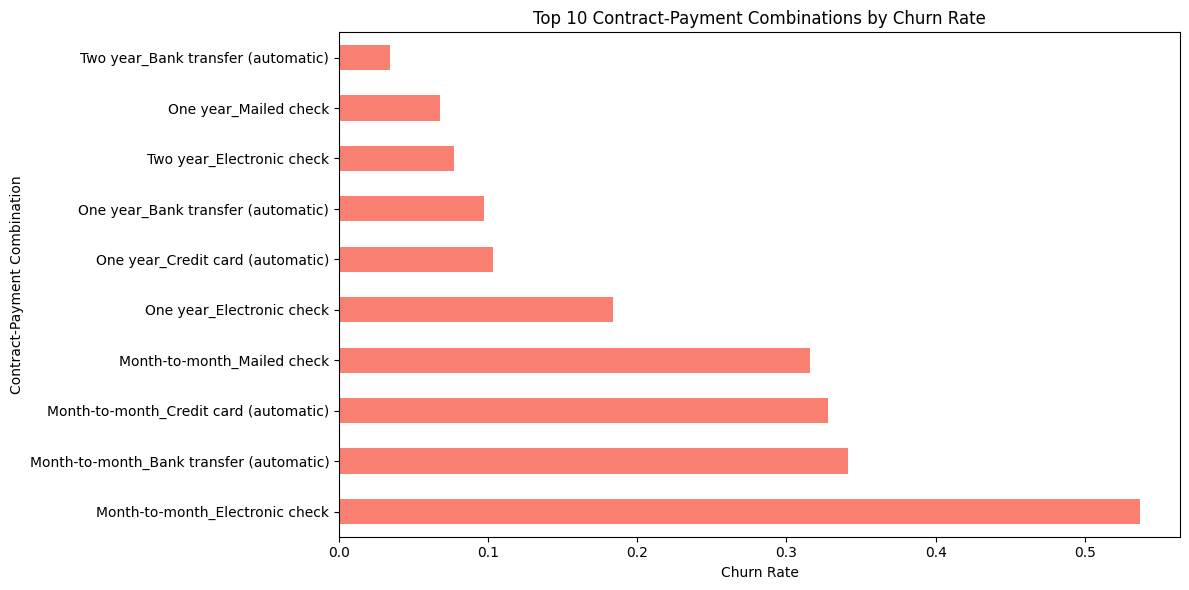

Top combinations:
                                          churn_rate  count
contract_payment                                           
Month-to-month_Electronic check                0.537   1850
Month-to-month_Bank transfer (automatic)       0.341    589
Month-to-month_Credit card (automatic)         0.328    543
Month-to-month_Mailed check                    0.316    893
One year_Electronic check                      0.184    347
One year_Credit card (automatic)               0.103    398
One year_Bank transfer (automatic)             0.097    391
Two year_Electronic check                      0.077    168
One year_Mailed check                          0.068    337
Two year_Bank transfer (automatic)             0.034    564


In [7]:
# Contract + Payment Method interaction
df_fe['contract_payment'] = df_fe['Contract'] + '_' + df_fe['PaymentMethod']

# Top 10 combinations by churn rate
contract_payment_churn = df_fe.groupby('contract_payment').agg({
    'Churn': ['mean', 'count']
}).round(3)
contract_payment_churn.columns = ['churn_rate', 'count']
contract_payment_churn = contract_payment_churn[contract_payment_churn['count'] >= 20]  # Filter small groups
top_10 = contract_payment_churn.sort_values('churn_rate', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_10['churn_rate'].plot(kind='barh', color='salmon')
plt.title('Top 10 Contract-Payment Combinations by Churn Rate')
plt.xlabel('Churn Rate')
plt.ylabel('Contract-Payment Combination')
plt.tight_layout()
plt.show()

print("Top combinations:")
print(top_10)

In [8]:
# Has phone service flag
df_fe['has_phone'] = (df_fe['PhoneService'] == 'Yes').astype(int)

# Has internet service flag
df_fe['has_internet'] = (df_fe['InternetService'] != 'No').astype(int)

# Has fiber optic (high churn indicator)
df_fe['has_fiber'] = (df_fe['InternetService'] == 'Fiber optic').astype(int)

# Month-to-month contract (high churn indicator)
df_fe['is_monthly_contract'] = (df_fe['Contract'] == 'Month-to-month').astype(int)

# Electronic check payment (high churn indicator)
df_fe['is_electronic_check'] = (df_fe['PaymentMethod'] == 'Electronic check').astype(int)

# Senior citizen (already 0/1)
df_fe['is_senior'] = df_fe['SeniorCitizen']

# No protection services (high risk)
df_fe['no_protection'] = (
    ((df_fe['OnlineSecurity'] == 'No') | (df_fe['OnlineSecurity'] == 'No internet service')) &
    ((df_fe['OnlineBackup'] == 'No') | (df_fe['OnlineBackup'] == 'No internet service')) &
    ((df_fe['DeviceProtection'] == 'No') | (df_fe['DeviceProtection'] == 'No internet service'))
).astype(int)

print("Binary flags created:")
print(df_fe[['has_phone', 'has_internet', 'has_fiber', 'is_monthly_contract', 
             'is_electronic_check', 'is_senior', 'no_protection']].head())

Binary flags created:
   has_phone  has_internet  has_fiber  is_monthly_contract  \
0          0             1          0                    1   
1          1             1          0                    0   
2          1             1          0                    1   
3          0             1          0                    0   
4          1             1          1                    1   

   is_electronic_check  is_senior  no_protection  
0                    1          0              0  
1                    0          0              0  
2                    0          0              0  
3                    0          0              0  
4                    1          0              1  


In [9]:
# List all new features
new_features = [
    'tenure_group', 'monthly_charges_bin', 
    'avg_monthly_charges', 'charges_ratio', 'service_count',
    'contract_payment',
    'has_phone', 'has_internet', 'has_fiber',
    'is_monthly_contract', 'is_electronic_check', 'is_senior',
    'no_protection'
]

print(f"Created {len(new_features)} new features:")
for feat in new_features:
    print(f"  - {feat}")

print(f"\nOriginal features: {df.shape[1]}")
print(f"After feature engineering: {df_fe.shape[1]}")
print(f"New features added: {df_fe.shape[1] - df.shape[1]}")

Created 13 new features:
  - tenure_group
  - monthly_charges_bin
  - avg_monthly_charges
  - charges_ratio
  - service_count
  - contract_payment
  - has_phone
  - has_internet
  - has_fiber
  - is_monthly_contract
  - is_electronic_check
  - is_senior
  - no_protection

Original features: 21
After feature engineering: 33
New features added: 12


In [10]:
# Save for later use
fe_path = Path("../data/features")
fe_path.mkdir(parents=True, exist_ok=True)

output_path = fe_path / "data_with_features.csv"
df_fe.to_csv(output_path, index=False)
print(f"✅ Saved feature-engineered data to {output_path}")

✅ Saved feature-engineered data to ../data/features/data_with_features.csv
